In [3]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow.keras 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer

In [84]:
dfstocks = pd.read_csv('../../../data/S&PFinanceData2020.csv',parse_dates = True)
dftweets = pd.read_csv('../../../data/stocktwits_SPXClassified.csv', parse_dates = True)
dftweets.head()

,Unnamed: 0,symbol,message,datetime,user,message_id,sentiment
0,0,SPX,$spy $spx looking for more green tomorrow but ...,2020-12-16T21:15:21Z,226994,264863118,NaN
1,1,SPX,$SPY Can just use this Headline for the next 4...,2020-12-16T21:11:34Z,1078695,264861500,0.0
2,2,SPX,"$SPX +0.2%, $NDX +0.6% \nAll about FOMC and St...",2020-12-16T21:07:06Z,322291,264859501,NaN
3,3,SPX,S&amp;P 500 Stocks At X-Day High [15-Dec]:\n\n...,2020-12-16T21:00:45Z,313661,264856112,NaN
4,4,SPX,$SPY $SPX Wilshire 5000 Broad Measure Cycle is...,2020-12-16T21:00:20Z,21210,264855893,1.0


In [85]:
def sentimentIndex(x):
    return np.log( (1 + x[1]) / (1 + x[0]))

In [86]:
dftweets = dftweets.dropna()
dftweets['sentiment'] = dftweets['sentiment'].astype('int')
rowsdifference = dfstocks.iloc[:, 5]
dfstocks['Difference'] = rowsdifference.diff()
dfstocks['Date'] = pd.to_datetime(dfstocks['Date'])
dfstocks['Difference'].iloc[0] = 0
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'])
dftweets['datetime'] = pd.to_datetime(dftweets['datetime'].dt.date)
dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2021-01-01")]
dftweets = dftweets.pivot_table(index='datetime',columns='sentiment', aggfunc='size')
print(dftweets[1])
dftweets['sentimentIndex'] = dftweets.apply(sentimentIndex, axis = 1)

dftweets.sort_values('datetime', inplace=True, ascending=True)
#rowsdiff2 = dftweets['sentimentIndex']
#dfstocks.set_index('Date').diff()
#rowsdiff2.diff()
#dftweets['Differencetweets'] = rowsdiff2
#dftweets['Differencetweets'].iloc[0] = 0


merged = pd.merge(left=dftweets, left_on='datetime',
         right=dfstocks, right_on='Date')
direction = []
for i in merged['Difference']:
    if i > 0:
        direction.append(1)
    else:
        direction.append(0)
merged['Direction'] = direction
merged = merged[1:]

merged.head()

datetime
2020-01-01     4
2020-01-02    23
2020-01-03    15
2020-01-04     2
2020-01-05     2
              ..
2020-12-12    17
2020-12-13    17
2020-12-14    29
2020-12-15    19
2020-12-16    17
Name: 1, Length: 351, dtype: int64


,0,1,sentimentIndex,Date,Open,High,Low,Close,Adj Close,Volume,Difference,Direction
1,58,15,-1.304949,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3461290000,-23.000000,0
2,14,13,-0.068993,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,11.429932,1
3,23,19,-0.182322,2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,-9.100098,0
4,22,35,0.448025,2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,15.870117,1
5,21,15,-0.318454,2020-01-09,3266.030029,3275.580078,3263.669922,3274.699951,3274.699951,3638390000,21.649902,1


In [87]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


### BASELINE

In [89]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close', 'Direction']]

n_days = 1
n_features = 7
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days, n_features*n_days + 6):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[7, 8, 9, 10, 11, 12]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.661111,0.669722,0.688497,0.680923,0.108971,0.680923,0.0,1.0
2,0.654886,0.670211,0.683352,0.688726,0.142928,0.688726,1.0,0.0
3,0.672063,0.668844,0.695238,0.682513,0.102443,0.682513,0.0,1.0
4,0.669752,0.684542,0.698071,0.693347,0.150400,0.693347,1.0,1.0
5,0.689141,0.690570,0.716111,0.708127,0.137234,0.708127,1.0,0.0
...,...,...,...,...,...,...,...,...
237,1.000000,1.000000,0.981272,0.979909,0.388030,0.979909,0.0,0.0
238,0.966897,0.975986,0.971010,0.976687,0.293604,0.976687,0.0,0.0
239,0.964742,0.967074,0.963139,0.973520,0.253533,0.973520,0.0,0.0
240,0.978301,0.989530,0.971451,0.962617,0.289882,0.962617,0.0,1.0


In [90]:
train_size = int(merged.shape[0]*0.7)

n_obs = n_days * n_features
values = dataset.values
train, test =  values[0:train_size, :], values[train_size:len(values), :]
train_X, train_y = train[:,:n_obs], train[:,-1]
test_X, test_y = test[:,:n_obs], test[:,-1]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

In [91]:
batch_size = 32
time_steps = 1
input_dim = (train_X.shape[1], train_X.shape[2])
#np.random.seed(420)
epochs = 50

Epoch 1/50
6/6 [==============================] - 2s 81ms/step - loss: 0.6939 - accuracy: 0.5245 - val_loss: 0.6990 - val_accuracy: 0.5278
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6710 - accuracy: 0.6077 - val_loss: 0.7298 - val_accuracy: 0.5278
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.6698 - accuracy: 0.5936 - val_loss: 0.7197 - val_accuracy: 0.5278
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 0.6613 - accuracy: 0.6074 - val_loss: 0.7224 - val_accuracy: 0.5278
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6632 - accuracy: 0.5993 - val_loss: 0.7219 - val_accuracy: 0.5278
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 0.6589 - accuracy: 0.6213 - val_loss: 0.7299 - val_accuracy: 0.5278
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.6652 - accuracy: 0.6225 - val_loss: 0.7327 - val_accuracy: 0.5278
Epoch 8/50
6/6 [===========

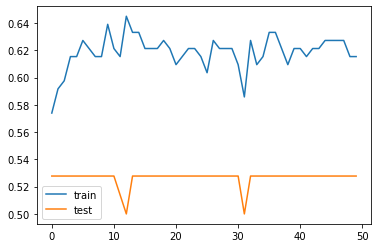

In [93]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences = True))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_y,
                validation_data = (test_X, test_y),
                batch_size=batch_size,
                epochs=epochs)
            
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [94]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 128)            69632     
_________________________________________________________________
attention_score_vec (Dense)  (None, 1, 128)            16384     
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score (Dot)        (None, 1)                 0         
_________________________________________________________________
attention_weight (Activation (None, 1)                 0         
_________________________________________________________________
context_vector (Dot)         (None, 128)               0         
_________________________________________________________________
attention_output (Concatenat (None, 256)              

In [95]:
predictions = (model.predict(test_X) >= 0.5).astype("int")
from sklearn.metrics import classification_report
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        34
         1.0       0.53      1.00      0.69        38

    accuracy                           0.53        72
   macro avg       0.26      0.50      0.35        72
weighted avg       0.28      0.53      0.36        72



### SA LSTM

In [92]:
#https://github.com/philipperemy/keras-attention-mechanism
class Attention(Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def __call__(self, hidden_states):
        hidden_size = int(hidden_states.shape[2])
        score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
        score = dot([score_first_part, h_t], [2, 1], name='attention_score')
        attention_weights = Activation('softmax', name='attention_weight')(score)
        context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
        pre_activation = concatenate([context_vector, h_t], name='attention_output')
        attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
        return attention_vector

In [99]:
merged_sim  = merged[ ['Open', 'High', 'Low', 'Adj Close', 'Volume','Close', 'sentimentIndex','Direction']]

n_days = 1
n_features = 8
dataset = merged_sim.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset = series_to_supervised(dataset, n_days,1)

droplist = []
for i in range(n_features*n_days-1, n_features*n_days + 7):
    droplist.append(i)
print(droplist)
dataset.drop(dataset.columns[droplist], axis = 1, inplace = True)
dataset

[7, 8, 9, 10, 11, 12, 13, 14]


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t)
1,0.661111,0.669722,0.688497,0.680923,0.108971,0.680923,0.240787,1.0
2,0.654886,0.670211,0.683352,0.688726,0.142928,0.688726,0.591807,0.0
3,0.672063,0.668844,0.695238,0.682513,0.102443,0.682513,0.559621,1.0
4,0.669752,0.684542,0.698071,0.693347,0.150400,0.693347,0.738643,1.0
5,0.689141,0.690570,0.716111,0.708127,0.137234,0.708127,0.520958,0.0
...,...,...,...,...,...,...,...,...
237,1.000000,1.000000,0.981272,0.979909,0.388030,0.979909,0.373091,0.0
238,0.966897,0.975986,0.971010,0.976687,0.293604,0.976687,0.017883,0.0
239,0.964742,0.967074,0.963139,0.973520,0.253533,0.973520,0.367536,0.0
240,0.978301,0.989530,0.971451,0.962617,0.289882,0.962617,0.663182,1.0
